In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

## OBJECTIVE

- In this section, we will buid MachineLearning model to predict whether employee resign or not.
- We will try some methods to predict this class ;
    - First, we will try basic classifier with logistic regression,
    - Then, we also try with Nearest Neighbor.
    - Since our data is quite small, we will try ensemble model using RandomForest and GradientBoosting.

## << Model Building Section >>

### Load Data

In [2]:
df_ori = pd.read_csv("dataset HR analytics.csv")
df = pd.read_excel('data_clean.xlsx')

### Check Missing Value

In [3]:
df.isnull().sum()

MaritalStatusID         0
GenderID                0
EmpStatusID             0
RoleID                  0
LevelID                 0
PerfScoreID             0
Tribe                   0
RaceDesc                0
RecruitmentSource       0
EngagementSurvey        0
EmpSatisfaction         0
SpecialProjectsCount    0
DaysLateLast30          0
Absences                0
YearsOfWorking          0
Age                     0
DaysLastReview          0
PerfValue               0
LevelValue              0
ActiveStatus            0
dtype: int64

### Splitting Data Train - Test Split

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [5]:
df_fix = df.drop(['LevelID','PerfScoreID'], axis=1)

In [6]:
X = df_fix.drop('ActiveStatus', axis =1).copy()
y = df_fix['ActiveStatus'].map({'Yes' : 1, 'No': 0}).copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 24)

- We split the Data into 80% training and 20% testing.
- Then, dont forget to stratify the data, to keep our class portion is the same.

In [8]:
print('The Portion of YES and NO Class in ENTIRE DATA')
print(y.value_counts()/len(y))
print('-'*45)
print('The Portion of YES and NO Class in TRAINING DATA')
print(y_train.value_counts()/len(y_train))
print('-'*45)
print('The Portion of YES and NO Class in TEST DATA')
print(y_test.value_counts()/len(y_test))

The Portion of YES and NO Class in ENTIRE DATA
1    0.675958
0    0.324042
Name: ActiveStatus, dtype: float64
---------------------------------------------
The Portion of YES and NO Class in TRAINING DATA
1    0.676856
0    0.323144
Name: ActiveStatus, dtype: float64
---------------------------------------------
The Portion of YES and NO Class in TEST DATA
1    0.672414
0    0.327586
Name: ActiveStatus, dtype: float64


- Since we already split train and test data with stratify mode, but it is for Training and Test Data, for Training and Entire data we have to make sure the portion is equal.
- After we check, the portion is equal between ENTIRE data and TRAINING data as above.

### Make Pipeline 

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
numerical_ix = list(X.select_dtypes(include=['int64', 'float64']).columns)
categorical_ix = list(X.select_dtypes(include=['object', 'bool']).columns)
numerical_ix.remove('YearsOfWorking')

print(numerical_ix)
print(categorical_ix)

['EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences', 'Age', 'DaysLastReview', 'PerfValue', 'LevelValue']
['MaritalStatusID', 'GenderID', 'EmpStatusID', 'RoleID', 'Tribe', 'RaceDesc', 'RecruitmentSource']


In [11]:
numeric_transformer1 = StandardScaler() # for normal distribution "YearsofWorking"
numeric_transformer2 = MinMaxScaler()   # for not normal distribution feature
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # for Categorical Feature

In [12]:
preprocessor = ColumnTransformer(transformers = [
                 ('Normal', numeric_transformer1, ['YearsOfWorking']),
                 ('Not_normal', numeric_transformer2, numerical_ix),
                 ('Cat', categorical_transformer, categorical_ix)])

- This step, we create the preprocessing step, to make easier when we train the model.
- For Categorical Feature we use onehotencoder, and for Continues Feature we use Standard Scaler and MinMax Scaler.
- Note : YearsofWorking is Normally Distributed, we already knew that from EDA section before.

### Building Model for Training - Testing

- We will try 5 Models to see which one does it better in seperating Positive and Negative Class ;
    - Logistic Regression from Linear model
    - Ensemble Model, we try model Random Forest and Gradient Boosting
    - Neighbors Model, we try KNN Classifier
    - And lastly, we are also interested in Support Vector Machine

In [13]:
from sklearn.metrics import  accuracy_score, roc_curve, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [14]:
def evaluate_matrix(ytrue, ypred, name):
    matrix_name = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score','ROC']
    acc = accuracy_score(ytrue, ypred)
    roc = roc_auc_score(ytrue, ypred)
    prec = precision_score(ytrue, ypred, average='weighted')
    rec = recall_score(ytrue, ypred, average='weighted')
    f1 = f1_score(ytrue, ypred, average='weighted')
    
    matrix_dict = dict(zip(matrix_name, [name, acc, prec, rec, f1, roc]))
    
    return matrix_dict

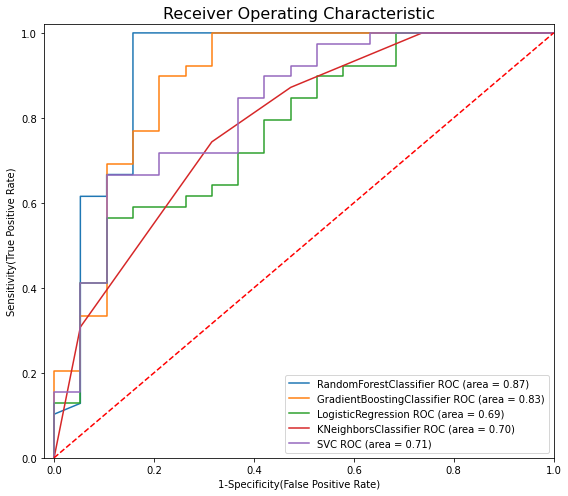

,Model,Accuracy,Precision,Recall,F1_Score,ROC,Cross_Val_Acc
0,RandomForestClassifier,0.913793,0.923589,0.913793,0.909859,0.868421,0.909316
1,GradientBoostingClassifier,0.879310,0.884908,0.879310,0.873802,0.829285,0.937508
2,LogisticRegression,0.758621,0.749779,0.758621,0.744612,0.685560,0.797822
3,KNeighborsClassifier,0.758621,0.750067,0.758621,0.750309,0.699055,0.766425
4,SVC,0.793103,0.797372,0.793103,0.775140,0.711201,0.815064


In [15]:
# Logistic Regression
lr_model = LogisticRegression()
# Random Forest
rf_model = RandomForestClassifier(random_state=40)
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=40)
# SVC
svc_model = SVC(probability=True)
# KNeighbors
knn_model = KNeighborsClassifier()


all_model = [rf_model, gb_model, lr_model, knn_model, svc_model]

matrix = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC']
model_results = pd.DataFrame(columns= matrix)

kfold = KFold(n_splits=5)
scoring = 'accuracy'

plt.figure(figsize=(8, 7))

for model in all_model:
    name = model.__class__.__name__
    
    model_pipe = Pipeline(steps=[('Preprocessor', preprocessor), ('Classifier', model)])
    
    # Evaluate with Cross Validation
    cv_acc = cross_val_score(estimator = model_pipe, X = X, y = y, cv = kfold, scoring=scoring)
    
    model_pipe.fit(X_train, y_train)
    y_predict = model_pipe.predict(X_test)
    
    matrix_dict = evaluate_matrix(y_test, y_predict, name)
    matrix_dict['Cross_Val_Acc'] = cv_acc.mean()
    model_results = model_results.append(matrix_dict, ignore_index=True)
    
    # Plot TRUE POSITIVE RATE AND FALSE POSITIVE RATE
    fpr, tpr, thresholds = roc_curve(y_test, model_pipe.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, matrix_dict['ROC']))

    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic', fontsize= 16)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

display(model_results)

- We already trained the model without tuning hyper-parameter, and we got as above.
- From result, we have 2 strong candidate of our model, RandomForest and GradientBoosting model.
- As general we can see RandomForest silghtly better than GradientBoosting.
- Because our data is quite not balance, with 68% portion is YES, and 32% is NO, we will focus to see F-1 score value, and Random forest gives us the highest score with 91%. And also RandomForest has the highest value of ROC.
- So we will choose RandomForest model to be used as our classifier model.

## Building Overall Model

- In this section we will put all the data including the transformation Age, YearsOfWorking etc in one Class, so we can use to predict with raw Data.
- And also we train all data into the final model, to give the model all the information that we have.

In [16]:
final_model_pipe = Pipeline(steps=[('Preprocessor', preprocessor), 
                             ('Classifier', RandomForestClassifier(random_state=40))])
final_model_pipe.fit(X, y)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Normal', StandardScaler(),
                                                  ['YearsOfWorking']),
                                                 ('Not_normal', MinMaxScaler(),
                                                  ['EngagementSurvey',
                                                   'EmpSatisfaction',
                                                   'SpecialProjectsCount',
                                                   'DaysLateLast30', 'Absences',
                                                   'Age', 'DaysLastReview',
                                                   'PerfValue', 'LevelValue']),
                                                 ('Cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MaritalStatusID',
                                                   'GenderID', 'EmpS

In [17]:
class ModelPredictor():
    def __init__(self, data):
        self.today_assumsion =  dt.now()
        self.model = final_model_pipe
        
        self.dict_level = {'Senior': 3, 'Middle': 2, 'Junior': 1}
        
        self.dict_perf = {'Exceed': 5,
                 'Fully meets': 4,
                 'Average': 3,
                 'Need improvement': 2,
                 'Special treatment': 1}
        
        self.column_select = ['MaritalStatusID', 'GenderID', 'EmpStatusID', 'RoleID', 'Tribe',
                              'RaceDesc', 'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction',
                              'SpecialProjectsCount', 'DaysLateLast30', 'Absences', 'YearsOfWorking',
                              'Age', 'DaysLastReview', 'PerfValue', 'LevelValue']
        
        self.df = pd.DataFrame(data)

        
    def duration(self, date, terminate='NaT', option = 'Y'):
        date = pd.to_datetime(date)
        
        if str(terminate) == 'NaT':
            days = self.today_assumsion - date
        else:
            days = terminate - date

        result = np.timedelta64(days, 'ns').astype(f'timedelta64[{option}]')/np.timedelta64(1, f'{option}')

        return result
    
    def age(self, dob, terminate='NaT'):
        check_date = len(dob)- dob.rfind('/')
        if check_date == 3:
            date = list(dob)
            date.insert(6, '19')
            dob = ''.join(date)

        date_dob = pd.to_datetime(dob)

        if str(terminate) == 'NaT':
            days = self.today_assumsion - date_dob
        else:
            days = terminate - date_dob

        year = np.timedelta64(days, 'ns').astype('timedelta64[Y]')/np.timedelta64(1, 'Y')

        return year
        
    def make_prediction(self):
        df = self.df.copy()
        df['LevelValue'] = df['LevelID'].map(self.dict_level)
        df['PerfValue'] = df['PerfScoreID'].map(self.dict_perf)
        df['YearsOfWorking'] = df.apply(lambda x : self.duration(x['DateofHire']), axis=1)
        df['Age'] = df.apply(lambda x : self.age(x['DOB']), axis=1)
        df['DaysLastReview'] = df.apply(lambda x : self.duration(x['LastPerformanceReview_Date'], option='D'), axis=1)
        
        final_df = df[self.column_select]
        
        predict = self.model.predict(final_df)
        
        return predict

In [18]:
test_data = df_ori.iloc[X_test.index]
res_final = ModelPredictor(test_data).make_prediction()
accuracy_score(y_test, res_final)

0.9655172413793104

- After testing with Raw Data, we get our score 96% on Accuracy, it seems our model is good enough to make a Prediction.

## << END of Model Building Section >>